In [1]:
 cd C:\Users\LIMDAESUN\Desktop\카이스트관련\UIUC\FE1\snowball

C:\Users\LIMDAESUN\Desktop\카이스트관련\UIUC\FE1\snowball


 # Snowball Swap Structure
 ### maturity = 15Y
 ### 계약 시작 : 2007년 1월 1일
 ### Receive Coupon Rate 4.76% (Semi Ann)
 ### Pay Coupon Rate = 1.76 (Semi Ann)
 ### 2009년 3월부터 Additional Spread를 추가로 지급해야함
 ###  Additional Spread = 이전 Quarter에 지급한 스프레드 + 다음항목
 #### - 1. EURIBOR< 2% 경우 : 2 * (2%-EURIBOR 3month)
 #### - 2. EURIBOR> 6% 경우 : 2 * (EURIBOR 3month - 6%)
 #### - 3. EURIBOR= 2%~6%
 #### - 4. Total Payment Spread >= 0 
 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm

 # Data Preprocessing

In [3]:
np.random.seed(0)

In [4]:
EURIBOR3 = pd.read_excel(r'C:\Users\LIMDAESUN\Desktop\카이스트관련\UIUC\FE1\snowball\EURIBOR3MO.xlsx' )

EURIBOR3 = pd.concat([ pd.DataFrame(EURIBOR3.columns , index = EURIBOR3.columns).T , 
           EURIBOR3], axis = 0)
EURIBOR3.columns = ['Date','EURIBOR3']
EURIBOR3 = EURIBOR3.set_index('Date')/100

EURIBOR3 = pd.concat([EURIBOR3, pd.DataFrame(np.nan, index = [datetime.datetime(2018,3,14)] , columns = ['EURIBOR3'] )] , axis = 0).resample('D').last()
EURIBOR3 = EURIBOR3.interpolate(method = 'cubic')
EURIBOR3 = EURIBOR3.fillna(method = 'ffill')

ZERO = pd.read_excel(r'C:\Users\LIMDAESUN\Desktop\카이스트관련\UIUC\FE1\snowball\Eurozone_zero_coupon_yield_curves.xlsx')
ZERO = ZERO.iloc[1:]/100
ZERO.index = np.r_[np.array([1/4,1/2,3/4]) ,np.arange(1,31) ]

In [5]:
EURIBOR3.head(10)

,EURIBOR3
1999-01-04,0.032212
1999-01-05,0.032123
1999-01-06,0.032073
1999-01-07,0.032025
1999-01-08,0.031975
1999-01-09,0.031950
1999-01-10,0.031939
1999-01-11,0.031922
1999-01-12,0.031872
1999-01-13,0.031784


In [6]:
ZERO.head(10)

,2013-12-13 00:00:00,2007-03-13 00:00:00
0.25,0.00242291,0.0367523
0.50,0.0039021,0.0378503
0.75,0.0048544,0.0384034
1.00,0.00550016,0.0386461
2.00,0.00733147,0.0385262
3.00,0.00985685,0.0381924
4.00,0.0131526,0.0380542
5.00,0.016647,0.0380965
6.00,0.019931,0.0382602
7.00,0.0228233,0.0384954


 # Calculate Additional Spread and Total Spread

In [7]:
Pay_Coupon = 0.0176
Receive_Coupon = 0.0476
Notional = 89083545

In [8]:
###########################################
####### Additional Spread Function ########
###########################################
def additional_spread(x) :
    if x < 0.02 : 
        return 2*(0.02-x)
    elif x>0.06 :
        return 2*(x-0.06)
    else :
        return -0.005
    
###########################################
##### Every month 13th days' index ########
###########################################
def every_13th(x) :
    return pd.to_datetime(str(x).split(' ')[0][:8] +'13')
Cday_lst = list(pd.Series(EURIBOR3['2009':].resample('Q').last().index).apply(every_13th))

###########################################
######## Calculate Total Spread ###########
###########################################
Spread = EURIBOR3.loc[Cday_lst].EURIBOR3.apply(additional_spread)
Spread.name = 'Spread'
Total_Spread = [Spread.iloc[0] if Spread.iloc[0]>0 else 0]
for i in range(1,len(Spread)) :
    Next_Spread = Total_Spread[i-1] + Spread.iloc[i]
    if Next_Spread < 0 :
        Next_Spread = 0
    Total_Spread.append(Next_Spread)
Total_Spread = pd.DataFrame(Total_Spread, index = EURIBOR3.loc[Cday_lst].index , columns = ['Total_Spread'])

In [9]:
Receive_Coupon_Amount = np.arange(len(Total_Spread))%2 * Receive_Coupon/2
Pay_Coupon_Amount = np.arange(len(Total_Spread))%2 * Pay_Coupon/2
Receive = pd.DataFrame(Receive_Coupon_Amount, index = EURIBOR3.loc[Cday_lst].index , columns = ['Receive'])
Pay = pd.DataFrame(Pay_Coupon_Amount, index = EURIBOR3.loc[Cday_lst].index , columns = ['Pay'])

 ## Q1. PAYOFF

In [10]:
Payoff_Q = pd.DataFrame(Receive.Receive - (Pay.Pay+ Total_Spread.Total_Spread) , columns = ['Payoff_Q'])
Payoff_Dollar = pd.DataFrame(Payoff_Q.Payoff_Q * Notional).rename(columns = {'Payoff_Q' : 'Payoff_Dollar'})

In [11]:
my_data = pd.concat([EURIBOR3.loc[Cday_lst],Spread, Total_Spread, Receive, Pay , Payoff_Q , Payoff_Dollar] ,axis = 1)
my_data

,EURIBOR3,Spread,Total_Spread,Receive,Pay,Payoff_Q,Payoff_Dollar
2009-03-13,0.016425,0.007150,0.007150,0.0000,0.0000,-0.007150,-6.369473e+05
2009-06-13,0.012547,0.014906,0.022056,0.0238,0.0088,-0.007056,-6.285976e+05
2009-09-13,0.007270,0.025461,0.047517,0.0000,0.0000,-0.047517,-4.233000e+06
2009-12-13,0.006770,0.026461,0.073978,0.0238,0.0088,-0.058978,-5.253961e+06
2010-03-13,0.005970,0.028061,0.102039,0.0000,0.0000,-0.102039,-9.089962e+06
2010-06-13,0.006519,0.026962,0.129000,0.0238,0.0088,-0.114000,-1.015555e+07
2010-09-13,0.008247,0.023506,0.152507,0.0000,0.0000,-0.152507,-1.358582e+07
2010-12-13,0.009556,0.020887,0.173394,0.0238,0.0088,-0.158394,-1.411029e+07
2011-03-13,0.011282,0.017436,0.190830,0.0000,0.0000,-0.190830,-1.699980e+07
2011-06-13,0.014181,0.011637,0.202467,0.0238,0.0088,-0.187467,-1.670025e+07


In [12]:
## my_data.to_excel(r'C:\Users\LIMDAESUN\Desktop\카이스트관련\UIUC\FE1\snowball\Snowball_Q1_Payoff.xlsx')

In [13]:
print('Total_Payoff= $'  , int(my_data.Payoff_Dollar.sum()) )

Total_Payoff= $ -1691359936


 # 2-1.
 # - set kappa, sigma, r(0)

In [14]:
kapa = 0.2
sigma = 0.0065
r0 =ZERO[ZERO.columns[0]].iloc[0]

In [15]:
pd.DataFrame([kapa, sigma, r0], index = ['kappa','sigma','r(0)'], columns = ['Q2']).T

,kappa,sigma,r(0)
Q2,0.2,0.0065,0.002423


# -simulate r(t) with Analytic folmula
 \begin{align}
 \ r(t) \sim  N(\mu, \nu^{2}) \\
 \\
 \ \mu = r(0) e^{-\kappa t} + r^{\star} (1-e^{-\kappa t})\\
 \\
 \ \nu = \frac {\sigma^2}{2\kappa}(1-e^{-2\kappa t}) \
\end{align}


In [16]:
T = 30
N = 300
path_num = 100
r_star_arange = np.arange(0.015,0.08,0.001).round(5)
r_star = r_star_arange.reshape(1,1,-1)
t = np.arange(0,T+T/N,T/N).reshape(-1,1,1)
my_shape = (N+1 , 1 , len(r_star_arange))

In [17]:
mu_ = r0*np.exp(-kapa * (t * np.ones(my_shape))) + r_star * np.ones(my_shape) * (1-np.exp(-kapa * t * np.ones(my_shape)))
v_ = sigma**2 / (2*kapa) * (1-np.exp(-2*kapa*t*np.ones(my_shape)))

In [18]:
r_t = (np.random.normal(0,1,path_num).reshape(1,-1,1)*v_ + mu_)

 \begin{align}
 \ G_1 (t)  = \frac{1}{\kappa} (1-e^{-\kappa t}) \\
 \\
 \ G_0 (t) = \frac{1}{\kappa^2} (G_1 (t) - t )(r^\star \kappa^2  - \frac {\sigma^2}{2} ) - \frac{(\sigma G_1 (t))^2}{4\kappa} \\
 \\
 \ B(t,r(t)) = exp(G_0 (t) - r(t) G_1 (t))\
\end{align}


In [19]:
time = t * np.ones(my_shape)
G1= (1/kapa) * (1-np.exp(-kapa * time))
G0 = (1/(kapa)**2) * (G1 - time) *( r_star*np.ones(my_shape) * kapa**2 - 0.5*sigma**2) - (sigma * G1)**2/(4*kapa)
B_t = np.exp(G0 - r_t * G1)
yield_curve_simul = -1/time[1:,:,:] * np.log(B_t[1:,:,:])

In [20]:
r0_array = r0* np.ones((1,yield_curve_simul.shape[1], yield_curve_simul.shape[2]))
y_curve_simul = np.concatenate([r0_array, yield_curve_simul], axis = 0)

In [21]:
Real_Rate = pd.DataFrame([], index = np.arange(0,T+T/(2*N),T/(2*N)) , columns = ['real_rate'])
Real_Rate.real_rate.loc[ZERO[ZERO.columns[0]].index] = ZERO[ZERO.columns[0]]
Real_Rate = Real_Rate.fillna(method = 'bfill')
Real_Rate = Real_Rate.loc[np.arange(0,T+T/N,T/N)]
Real_Rate = np.array(Real_Rate).reshape(-1,1,1)

In [22]:
ERROR = pd.DataFrame(np.abs(y_curve_simul - Real_Rate).mean(1).mean(0), index =r_star_arange , columns = ['mean_ERROR'] )
ERROR.index.name = 'r_star'
real_rate_curve = pd.DataFrame(Real_Rate.reshape(-1), columns = ['real_rate'] , index = np.arange(0,N+1)/(N/T))
col = [x.round(4) for x in r_star_arange]
mean_simul_curve = pd.DataFrame(y_curve_simul.mean(1) , columns = col, index = np.arange(0,N+1)/(N/T))

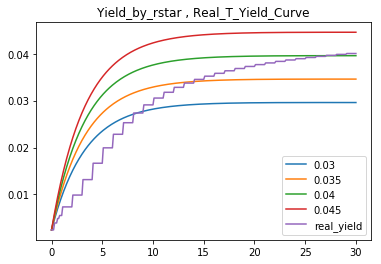

In [23]:
mean_simul_curve[mean_simul_curve.columns[15:-30:5]].plot()
plt.plot(real_rate_curve , label = 'real_yield' )
plt.legend(loc = 'best')
plt.title('Yield_by_rstar , Real_T_Yield_Curve')
plt.show()

In [24]:
min_error = ERROR[ERROR.mean_ERROR == ERROR.mean_ERROR.min()]
min_error

,mean_ERROR
r_star,
0.037,0.004143


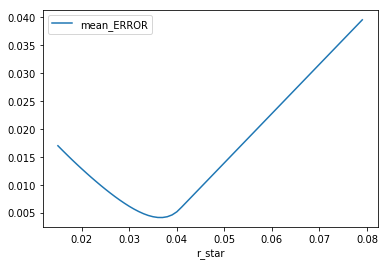

In [25]:
ERROR.plot()
plt.show()

 # simulate with individual r(t)  and dr(t)

In [26]:
T = 30
N = 300
dt = T/N
path_num = 100
dW = np.random.normal(0,1,(N,path_num)) * np.sqrt(dt)
t = np.arange(0,T+T/N,T/N).reshape(-1,1,1)
r_star_arange = np.arange(0.015,0.08,0.001).round(5)
r_star = r_star_arange.reshape(1,1,-1)
r_t = np.zeros((dW.shape[0]+1,path_num, r_star.shape[2]))
d_r_t = np.zeros((dW.shape[0] , dW.shape[1], r_star.shape[2]))
my_shape = (N+1 , 1 , len(r_star_arange))
r_t[0] = r0

In [27]:
for i in range(1,N+1) :
    d_r_t[i-1] = kapa * (r_star - r_t[i-1]) * dt + sigma * dW[i-1].reshape(-1,1)
    r_t[i] = r_t[i-1] + d_r_t[i-1]

 # -for a range of r , evaluate G0(t,T) G1(t,T) and B(t,T) 

In [28]:
time = t * np.ones(my_shape)
G1= (1/kapa) * (1-np.exp(-kapa * time))
G0 = (1/(kapa)**2) * (G1 - time) *( r_star*np.ones(my_shape) * kapa**2 - 0.5*sigma**2) - (sigma * G1)**2/(4*kapa)
B_t = np.exp(G0 - r_t * G1)
yield_curve_simul = -1/time[1:,:,:] * np.log(B_t[1:,:,:])

In [29]:
r0_array = r0* np.ones((1,yield_curve_simul.shape[1], yield_curve_simul.shape[2]))
y_curve_simul = np.concatenate([r0_array, yield_curve_simul], axis = 0)

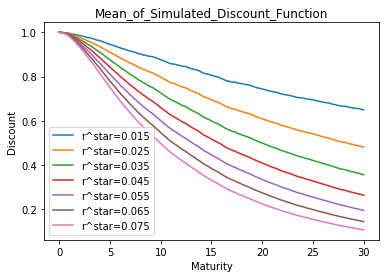

In [30]:
Simulated_B_t = pd.DataFrame(B_t.mean(1), columns = r_star_arange, index = np.arange(0,30.1,0.1).round(4) )
for i in Simulated_B_t.columns[::10] :
    plt.plot(Simulated_B_t[i] , label = 'r^star='+str(i))
plt.legend(loc = 'best')
plt.title('Mean_of_Simulated_Discount_Function')
plt.xlabel('Maturity')
plt.ylabel('Discount')
plt.show()

 # -1. Find r_star and Vasicek Simulation

In [31]:
ERROR = pd.DataFrame(np.abs(y_curve_simul - Real_Rate).mean(1).mean(0), index =r_star_arange , columns = ['mean_ERROR'] )
ERROR.index.name = 'r_star'
real_rate_curve = pd.DataFrame(Real_Rate.reshape(-1), columns = ['real_rate'] , index = np.arange(0,N+1)/(N/T))
col = [x.round(4) for x in r_star_arange]
mean_simul_curve = pd.DataFrame(y_curve_simul.mean(1) , columns = col, index = np.arange(0,N+1)/(N/T))

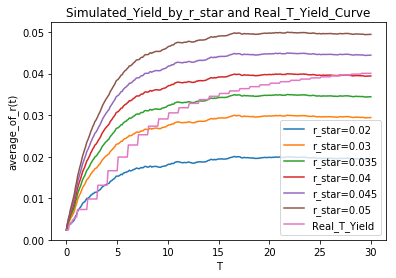

In [32]:
plst = [0.02, 0.03 , 0.035, 0.04, 0.045, 0.05]
for i in plst :
    plt.plot(mean_simul_curve[i] , label = 'r_star='+str(i))
plt.plot(real_rate_curve, label = 'Real_T_Yield')
plt.xlabel('T')
plt.ylabel('average_of_r(t)')
plt.legend(loc = 'best')
plt.title('Simulated_Yield_by_r_star and Real_T_Yield_Curve')
plt.show()

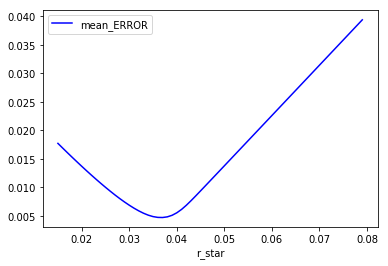

In [33]:
ERROR.plot(color = 'blue')
plt.show()

In [34]:
min_error = ERROR[ERROR.mean_ERROR == ERROR.mean_ERROR.min()]
min_error

,mean_ERROR
r_star,
0.037,0.004701


 # Q2. 
 # - Set r(0) , r^star ,Total_Spread(0)

In [35]:
Expiration_date = datetime.datetime(2022,12,13)
time_2013_to_2022 = ((datetime.datetime(2022,12,13)- datetime.datetime(2013,12,13)).days)/365
days_2013_to_2022 = ((datetime.datetime(2022,12,13)- datetime.datetime(2013,12,13)).days)

In [36]:
r0_2013 = EURIBOR3.loc['2013-12-13'][0]
r_star_ = min_error.index[0]
Total_Spread_2013_4Q = Total_Spread.loc['2013-12-13'][0]

In [37]:
pd.DataFrame([r0_2013,r_star_,Total_Spread_2013_4Q], index = ['r(0)', 'r^star','Initial_Spread'], columns = ['Q2-2']).T


,r(0),r^star,Initial_Spread
Q2-2,0.002557,0.037,0.499676


 # -Simulate Vasicek Model (path  = 10000, period = 2013~2022)

In [38]:
path_num_ = 10000
T_ = time_2013_to_2022
N_ = days_2013_to_2022
dt_ = T_/N_
dW_ = np.random.normal(0,1,(N_,path_num_)) * np.sqrt(dt_)

In [39]:
t_ = np.arange(0,T_+T_/N_,T_/N_).reshape(-1,1)
r_star_= min_error.index[0]
r_t_ = np.zeros((dW_.shape[0]+1,dW_.shape[1]))
d_r_t_ = np.zeros(dW_.shape)

In [40]:
r_t_[0] = r0_2013
for i in range(1,N_+1) :
    d_r_t_[i-1] = kapa * (r_star_ - r_t_[i-1]) * dt_ + sigma * dW_[i-1]
    r_t_[i] = r_t_[i-1] + d_r_t_[i-1]

In [41]:
index_2013_2022 = pd.date_range('12/13/2013', periods=N_+1)
Simulated_r_t_ = pd.DataFrame(r_t_, index = index_2013_2022)

 # - Example 10 Sample of 10000 plotting

In [42]:
#Simulated_r_t_.astype(np.float16).to_csv(r'C:\Users\LIMDAESUN\Desktop\카이스트관련\UIUC\FE1\snowball\Snowball_Q2_MC_result.csv')

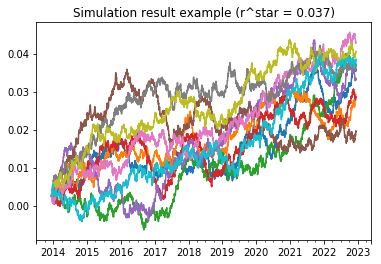

In [43]:
pd.DataFrame(Simulated_r_t_).sample(n = 10, axis = 1).plot(legend=None)
plt.title('Simulation result example (r^star = '+str(r_star_) + ')')
plt.show()

In [44]:
Discount_Factor = np.exp(-Simulated_r_t_ * dt_).cumprod(0)

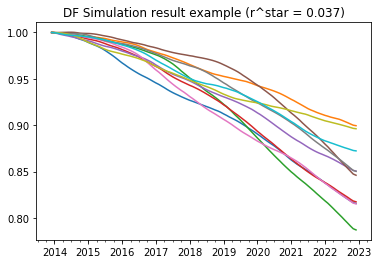

In [45]:
Discount_Factor.resample('M').last().sample(10, axis = 1).plot(legend = None)
plt.title('DF Simulation result example (r^star = '+str(r_star_) + ')')
plt.show()

 # - Calcuate Additional Spread and Total Spread

In [46]:
###########################################
##### Every month 13th days' index ########
###########################################

Cday_lst_ = list(pd.Series(Simulated_r_t_.loc['2013-12-13':].resample('Q').last().index).apply(every_13th))

In [47]:
Short_Rate = Simulated_r_t_.loc[Cday_lst_]
Spread_ = Short_Rate.applymap(additional_spread)
Total_Spread_=pd.DataFrame([] , index = Spread_.index, columns = Spread_.columns)
Total_Spread_.iloc[0] = Total_Spread_2013_4Q
for i in range(1,len(Spread_.index)) :
    Next_Spread = Total_Spread_.iloc[i-1] + Spread_.iloc[i]
    Total_Spread_.iloc[i] = (Next_Spread>0)*Next_Spread

 # - Calculate Payoff and Discounted Payoff

In [48]:
Receive_Coupon_Amount_ = (1-np.arange(len(Total_Spread_))%2) * Receive_Coupon/2
Pay_Coupon_Amount_ = (1-np.arange(len(Total_Spread_))%2) * Pay_Coupon/2
Receive_ = pd.DataFrame(Receive_Coupon_Amount_, index = Cday_lst_ , columns = ['Receive'])
Pay_ = pd.DataFrame(Pay_Coupon_Amount_, index = Cday_lst_, columns = ['Pay'])

In [49]:
Payoff_after_13 = pd.DataFrame(np.array((Receive_.Receive - Pay_.Pay)).reshape(-1,1) * np.ones(Total_Spread_.shape) - np.array(Total_Spread_), index = Total_Spread_.index)
Value_at_2013_end = (Discount_Factor.loc[Payoff_after_13.index].iloc[1:] * Payoff_after_13.iloc[1:] * Notional).sum(0).mean()

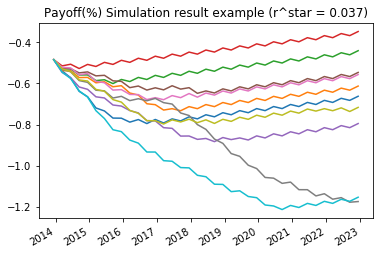

In [50]:
Payoff_after_13.sample(10, axis = 1).plot(legend = None)
plt.title('Payoff(%) Simulation result example (r^star = '+str(r_star_) + ')')
plt.show()

In [51]:
print('Value of Swap is $',int(Value_at_2013_end))

Value of Swap is $ -2049842175


 # Q3.

In [52]:
kapa = 0.04
sigma = 0.0065
r0  =ZERO[ZERO.columns[1]].iloc[0]

 # - Re-estimate r^star

In [53]:
T = 30
N = 300
dt = T/N
path_num = 100
dW = np.random.normal(0,1,(N,path_num)) * np.sqrt(dt)
t = np.arange(0,T+T/N,T/N).reshape(-1,1,1)
r_star_arange = np.arange(0.015,0.08,0.001).round(5)
r_star = r_star_arange.reshape(1,1,-1)
r_t = np.zeros((dW.shape[0]+1,path_num, r_star.shape[2]))
d_r_t = np.zeros((dW.shape[0] , dW.shape[1], r_star.shape[2]))
my_shape = (N+1 , 1 , len(r_star_arange))
r_t[0] = r0

In [54]:
for i in range(1,N+1) :
    d_r_t[i-1] = kapa * (r_star - r_t[i-1]) * dt + sigma * dW[i-1].reshape(-1,1)
    r_t[i] = r_t[i-1] + d_r_t[i-1]

In [55]:
time = t * np.ones(my_shape)
G1= (1/kapa) * (1-np.exp(-kapa * time))
G0 = (1/(kapa)**2) * (G1 - time) *( r_star*np.ones(my_shape) * kapa**2 - 0.5*sigma**2) - (sigma * G1)**2/(4*kapa)
B_t = np.exp(G0 - r_t * G1)
yield_curve_simul = -1/time[1:,:,:] * np.log(B_t[1:,:,:])
r0_array = r0* np.ones((1,yield_curve_simul.shape[1], yield_curve_simul.shape[2]))
y_curve_simul = np.concatenate([r0_array, yield_curve_simul], axis = 0)

In [56]:
Real_Rate = pd.DataFrame([], index = np.arange(0,T+T/(2*N),T/(2*N)) , columns = ['real_rate'])
Real_Rate.real_rate.loc[ZERO[ZERO.columns[1]].index] = ZERO[ZERO.columns[1]]
Real_Rate = Real_Rate.fillna(method = 'bfill')
Real_Rate = Real_Rate.loc[np.arange(0,T+T/N,T/N)]
Real_Rate = np.array(Real_Rate).reshape(-1,1,1)

In [57]:
ERROR = pd.DataFrame(np.abs(y_curve_simul - Real_Rate).mean(1).mean(0), index =r_star_arange , columns = ['mean_ERROR'] )
ERROR.index.name = 'r_star'
real_rate_curve = pd.DataFrame(Real_Rate.reshape(-1), columns = ['real_rate'] , index = np.arange(0,N+1)/(N/T))
col = [x.round(4) for x in r_star_arange]
mean_simul_curve = pd.DataFrame(y_curve_simul.mean(1) , columns = col, index = np.arange(0,N+1)/(N/T))

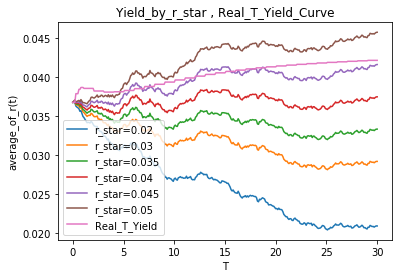

In [58]:
plst = [0.02, 0.03 , 0.035, 0.04, 0.045, 0.05]
for i in plst :
    plt.plot(mean_simul_curve[i] , label = 'r_star='+str(i))
plt.plot(real_rate_curve, label = 'Real_T_Yield')
plt.xlabel('T')
plt.ylabel('average_of_r(t)')
plt.legend(loc = 'best')
plt.title('Yield_by_r_star , Real_T_Yield_Curve')
plt.show()

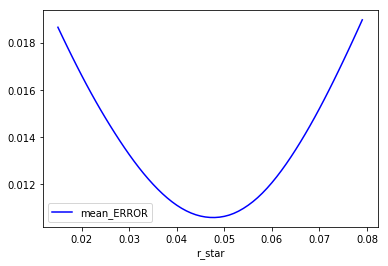

In [59]:
ERROR.plot(color = 'blue')
plt.show()

In [60]:
min_error_ = ERROR[ERROR.mean_ERROR == ERROR.mean_ERROR.min()]
min_error_

,mean_ERROR
r_star,
0.048,0.010584


 # - Re - do Simulate the Payoff

In [61]:
Expiration_date = datetime.datetime(2022,12,13)
time_2007_to_2022 = ((Expiration_date- datetime.datetime(2007,3,13)).days)/365
days_2007_to_2022 = ((Expiration_date- datetime.datetime(2007,3,13)).days)

In [62]:
r0_2007 = EURIBOR3.loc['2007-3-13'][0]
r_star__ = min_error_.index[0]

In [63]:
path_num__ = 10000
T__ = time_2007_to_2022
N__ = days_2007_to_2022
dt__ = T__/N__
dW__ = np.random.normal(0,1,(N__,path_num__)) * np.sqrt(dt__)

In [64]:
t__ = np.arange(0,T__+T__/N__,T__/N__).reshape(-1,1)
r_t__ = np.zeros((dW__.shape[0]+1,dW__.shape[1]))
d_r_t__ = np.zeros(dW__.shape)

In [65]:
r_t__[0] = r0_2007
for i in range(1,N__+1) :
    d_r_t__[i-1] = kapa * (r_star__ - r_t__[i-1]) * dt__ + sigma * dW__[i-1]
    r_t__[i] = r_t__[i-1] + d_r_t__[i-1]

In [66]:
index_2007_2022 = pd.date_range('3/13/2007', periods=N__+1)
Simulated_r_t__ = pd.DataFrame(r_t__, index = index_2007_2022)

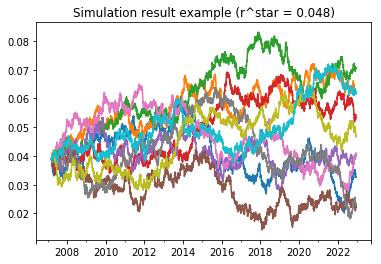

In [67]:
pd.DataFrame(Simulated_r_t__).sample(n = 10, axis = 1).plot(legend = None)
plt.title('Simulation result example (r^star = '+str(r_star__) + ')')
plt.show()

In [68]:
Discount_Factor__ = np.exp(-Simulated_r_t__ * dt__).cumprod(0)

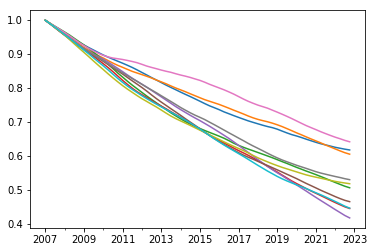

In [69]:
Discount_Factor__.resample('Q').last().sample(n = 10, axis = 1).plot(legend = None)
plt.show()

In [70]:
Spread_day_lst_ = list(pd.Series(Simulated_r_t__.loc['2009-3-13':].resample('Q').last().index).apply(every_13th))

In [71]:
Short_Rate__ = Simulated_r_t__.loc[Spread_day_lst_]
Spread__ = Short_Rate__.applymap(additional_spread)

In [72]:
Short_Rate__ = Simulated_r_t__.loc[Spread_day_lst_]
Spread__ = Short_Rate__.applymap(additional_spread)
Total_Spread__=pd.DataFrame([] , index = Spread__.index, columns = Spread__.columns)
Total_Spread__.iloc[0] = 0
for i in range(1,len(Spread__.index)) :
    Next_Spread__ = Total_Spread__.iloc[i-1] + Spread__.iloc[i]
    Total_Spread__.iloc[i] = (Next_Spread__>0)*Next_Spread__

In [73]:
CPN_Day_lst = list(pd.Series(EURIBOR3['2007': my_data.index[0]].resample('Q').last().index[:-1]).apply(every_13th))

In [74]:
All_period_TS = pd.concat([pd.DataFrame([], index = CPN_Day_lst  , columns = Total_Spread__.columns).fillna(0),
           Total_Spread__], axis = 0)

In [75]:
Receive_Coupon_Amount__ = np.arange(len(All_period_TS))%2 * Receive_Coupon/2
Pay_Coupon_Amount__ = np.arange(len(All_period_TS))%2 * Pay_Coupon/2
Receive__ = pd.DataFrame(Receive_Coupon_Amount__, index = All_period_TS.index , columns = ['Receive'])
Pay__ = pd.DataFrame(Pay_Coupon_Amount__, index = All_period_TS.index, columns = ['Pay'])

In [76]:
Payoff__ = pd.DataFrame(np.array((Receive__.Receive - Pay__.Pay)).reshape(-1,1) * np.ones(All_period_TS.shape) -
                        np.array(All_period_TS), index = All_period_TS.index)
Value_path = (Discount_Factor__.loc[Payoff__.index] * Payoff__ * Notional).sum(0).astype(np.int64)
Value_at_2007 = int(Value_path.mean())

In [77]:
MC_std = Value_path.std()

In [78]:
print('The Swap Value at 2007 is ', Value_at_2007 , ', MC_std = ' , int(MC_std))

The Swap Value at 2007 is  -137711235 , MC_std =  404987708


In [79]:
#Simulated_r_t__.loc[Spread_day_lst_].astype(np.float16).to_csv(r'C:\Users\LIMDAESUN\Desktop\카이스트관련\UIUC\FE1\snowball\Snowball_Q3_MC2007_result.csv')

In [80]:
R = Simulated_r_t__.loc[Spread_day_lst_]
num_excess_barrier = ((R>0.06).astype(np.int64) + (R<0.02).astype(np.int64)).sum(0)
Value_and_num = pd.concat([num_excess_barrier , Value_path/1000000], axis = 1 )
Value_and_num.columns = ['Num_excess_barrier','SwapValue']

In [81]:
V1 = Value_and_num[Value_and_num > Value_and_num.mean() -  3 * Value_and_num.SwapValue.std()].dropna()
V2 = V1[V1<Value_and_num.mean() +  3 * Value_and_num.SwapValue.std()]

In [82]:
Value_and_num.Num_excess_barrier.mean() , Value_and_num.Num_excess_barrier.std()

(11.2427, 13.516917822371013)

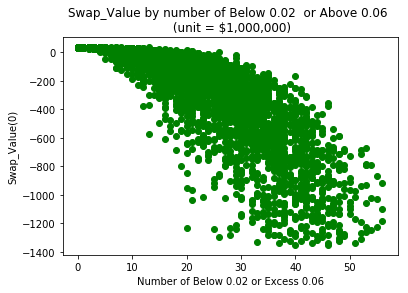

In [83]:
plt.scatter(V2.Num_excess_barrier , V2.SwapValue, color = 'green')
plt.title('Swap_Value by number of Below 0.02  or Above 0.06 \n (unit = $1,000,000)')
plt.xlabel('Number of Below 0.02 or Excess 0.06')
plt.ylabel('Swap_Value(0)')
plt.show()


 # Q4.
 
 \begin{align}
\ dr = \kappa (\bar{r} - r)dt + \sigma dW \\
\ dr = \kappa \bar{r} dt - \kappa r dt + \sigma \sqrt{dt} \bullet \epsilon \\ 
\ \frac{dr}{dt} =  \kappa \bar{r} \ - \kappa r + \sigma \frac{1}{\sqrt{dt}} \bullet \epsilon \\
\ \sigma = \sigma_{res} \times \sqrt{dt} \\
\ \frac{dr}{dt} =  \alpha \  + (- \kappa) r + \sigma \frac{1}{\sqrt{dt}} \bullet \epsilon \\
\end{align}

In [84]:
E = EURIBOR3.EURIBOR3[:'2006-12-31'].resample('M').last()
dr = E.diff()
dr_over_dt = (dr/(1/12)).dropna()

In [85]:
x1 = pd.DataFrame(E)
x = sm.add_constant(x1).loc[dr_over_dt.index]
results = sm.OLS(dr_over_dt,x).fit()

In [86]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               EURIBOR3   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8931
Date:                Sun, 05 Apr 2020   Prob (F-statistic):              0.347
Time:                        20:52:25   Log-Likelihood:                 248.69
No. Observations:                  95   AIC:                            -493.4
Df Residuals:                      93   BIC:                            -488.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0051      0.006     -0.780      0.437      -0.018       0.008
EURIBOR3       0.1907      0.202      0.945      0.347      -0.210       0.591
==============================================================================
Omnibus:                       19.691   Durbin-Watson:                   1.162
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.773
Skew:                          -0.715   Prob(JB):                     1.90e-10
Kurtosis:                       6.044   Cond. No.                         110.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [87]:
kappa_ = - results.params[1]
alpha = results.params[0]
longterm_mean = alpha/kappa_
sigma_data =  results.resid.std() * np.sqrt(1/12)

In [88]:
longterm_mean , kappa_ , sigma_data

(0.02657178600651175, -0.1907096011355998, 0.005123746128650639)